# ALeRCE basics

```Author: Alejandra Muñoz-Arancibia. Last updated: 20251023```

A brief set of examples on how to interact with the ALeRCE data using our custom python client (https://alerce.readthedocs.io/en/latest/index.html), including how to display object light curves and stamp cutouts.

*It is highly recommended that you try this notebook in Google Colab using the following [link](https://colab.research.google.com/github/alercebroker/usecases/blob/master/notebooks/MAS_Oct2025_tutorial/ALeRCE_Basics_MAS.ipynb).* This will avoid you from having to sort out library installation problems and focus on the contents of the tutorial. You can try installing the dependencies later in your own system.

### Some settings

First install the ALeRCE python client (uncomment the following line)

In [1]:
#!pip install alerce

Load libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from IPython.core.display import HTML

In [3]:
from alerce.core import Alerce

Initialize the ALeRCE client

In [4]:
client = Alerce()

### Choose a ZTF object

In [5]:
oid = "ZTF25abansec"

We can find this object in the ALeRCE Explorer as https://alerce.online/object/ZTF25abansec.

### Show its light curve

In [6]:
obj_dets = client.query_detections(oid, format='pandas')
obj_nondets = client.query_non_detections(oid, format='pandas')
obj_fp = client.query_forced_photometry(oid, format='pandas')

Note that when LSST starts its public stream, we will use an updated ALeRCE client version. The queries will change a little:

In [7]:
## Uncomment the following lines after the LSST stream starts
## Will work for an updated ALeRCE client version

#obj_dets = client.query_detections(oid, survey='ztf', format='pandas')
#obj_nondets = client.query_non_detections(oid, survey='ztf', format='pandas')
#obj_fp = client.query_forced_photometry(oid, survey='ztf', format='pandas')

We define a function to plot the light curve using difference magnitudes

In [8]:
def plot_lc(oid, obj_dets, obj_nondets, obj_fp):
    fig, ax = plt.subplots(figsize=(10, 4))
    labels = {1: 'g', 2: 'r', 3: 'i'}
    markers = {1: 'o', 2: 's', 3: 'X'}
    colors = {1: '#56E03A', 2: '#D42F4B', 3: '#F4D617'} 
    
    for fid in [1, 2]:
        mask = obj_dets["fid"] == fid
        if len(obj_dets[mask]) > 0:
            ax.errorbar(obj_dets[mask]["mjd"], obj_dets[mask]["magpsf"],
                        yerr=obj_dets[mask]["sigmapsf"], c=colors[fid],
                        label="%s (detection)" % labels[fid],
                        marker=markers[fid], linestyle='None')
        
        mask = (obj_nondets["fid"] == fid) & (obj_nondets["diffmaglim"] > -900)
        if len(obj_nondets[mask]) > 0:     
            ax.scatter(obj_nondets[mask]["mjd"],
                       obj_nondets[mask]["diffmaglim"],
                       c=colors[fid], alpha=0.5, marker='v',
                       label="%s (limit mag)" % labels[fid], s=20)

        if len(obj_fp) == 0:
            continue
        mask = (obj_fp["fid"] == fid) \
               & (obj_fp["mag"] / obj_fp["e_mag"] >= 3) \
               & (obj_fp["e_mag"] < 1.)
        if len(obj_fp[mask]) > 0:
            ax.errorbar(obj_fp[mask]["mjd"], obj_fp[mask]["mag"], 
                        yerr=obj_fp[mask]["e_mag"], c=colors[fid],
                        label="%s (forced phot)" % labels[fid],
                        marker=markers[fid], linestyle='None', alpha=0.3)
            
    ax.set_title(oid, fontsize=15)
    ax.set_xlabel("MJD", fontsize=15)
    ax.set_ylabel("Difference magnitude", fontsize=15)
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

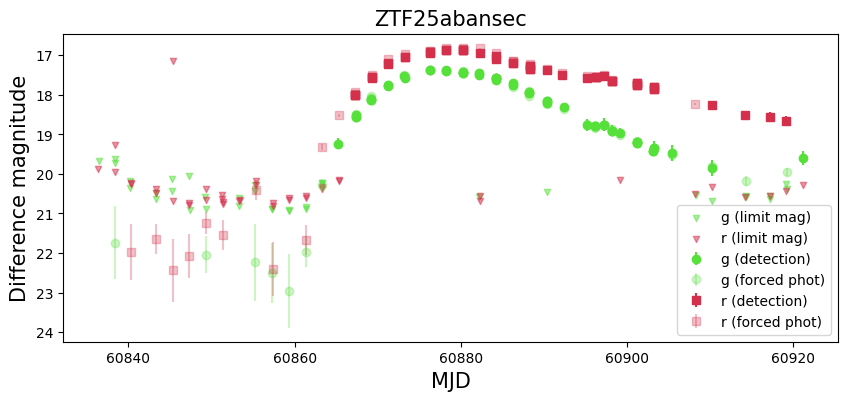

In [9]:
plot_lc(oid, obj_dets, obj_nondets, obj_fp)

### Show its first stamps (science, template and difference)

We first find the identifier of the first detection that has stamps

In [10]:
candid = obj_dets[obj_dets["has_stamp"]].sort_values(by="mjd").iloc[0]["candid"]

In [11]:
stamps = client.plot_stamps(oid, candid)

And when LSST starts, this query will be:

In [12]:
## Uncomment the following lines after the LSST stream starts
## Will work for an updated ALeRCE client version

#stamps = client.plot_stamps(oid, candid, survey='ztf')

### Query a list of ZTF objects based on their most likely class (i.e. their ranking = 1 probability) according to an ALeRCE light curve classifier

We query the top 500 objects classified as SNIa by `lc_classifier_BHRF_forced_phot` (Cabrera-Vives et al., in preparation), sort by probability in descending order:

In [13]:
query_results = client.query_objects(
    classifier="lc_classifier_BHRF_forced_phot",
    class_name="SNIa",
    page_size=500,
    order_by='probability',
    order_mode='DESC',
    format='pandas')

And for LSST, this becomes:

In [14]:
## Uncomment the following lines after the LSST stream starts
## Will work for an updated ALeRCE client version

#query_results = client.query_objects(
#    classifier="lc_classifier_BHRF_forced_phot",
#    class_name="SNIa",
#    page_size=500,
#    order_by='probability',
#    order_mode='DESC',
#    survey='ztf',
#    format='pandas')

We show some relevant columns

In [15]:
cols = ["oid", "ndet", "meanra", "meandec",
        "firstmjd", "lastmjd", "deltajd",
        "probability"]
query_results[cols]

,oid,ndet,meanra,meandec,firstmjd,lastmjd,deltajd,probability
0,ZTF25abioriw,44,353.977209,47.076469,60901.373599,60968.132639,66.759039,0.884000
1,ZTF25abckwuq,46,277.626621,26.831028,60878.257627,60948.219965,69.962338,0.874248
2,ZTF25aavdmzf,168,331.058529,-1.997467,60841.363715,60948.288472,106.924757,0.852852
3,ZTF25aakbqpl,33,136.705877,48.768694,60757.194803,60818.261759,61.066956,0.838000
4,ZTF25aaxnchn,65,316.960654,18.152163,60851.341424,60932.289687,80.948264,0.823472
...,...,...,...,...,...,...,...,...
495,ZTF25aamkdzv,21,246.109028,16.677673,60775.435706,60824.320035,48.884329,0.404064
496,ZTF25abugbyo,17,263.974826,55.673664,60948.158079,60969.162164,21.004086,0.404000
497,ZTF25absbrdm,18,278.813290,59.057612,60938.174039,60967.113276,28.939236,0.403920
498,ZTF25abagvaw,22,9.664391,9.996267,60863.467164,60889.323229,25.856065,0.403920


### Show their distribution of probabilities

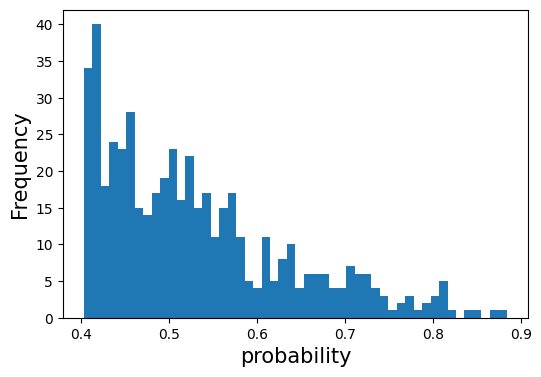

In [16]:
col = "probability"
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(query_results[col], bins=50)
ax.set_xlabel(col, fontsize=15)
ax.set_ylabel("Frequency", fontsize=15);

### Show their spatial coordinates

We display them together with the Galactic plane ($b = 0$)

In [17]:
gal_plane_l = np.linspace(0., 360., 360)
gal_plane_b = 0. * gal_plane_l
gal_plane_coords = SkyCoord(l=gal_plane_l, b=gal_plane_b,
                            unit=(u.deg, u.deg), frame="galactic")
gal_plane_ra = gal_plane_coords.icrs.ra.value
gal_plane_dec = gal_plane_coords.icrs.dec.value

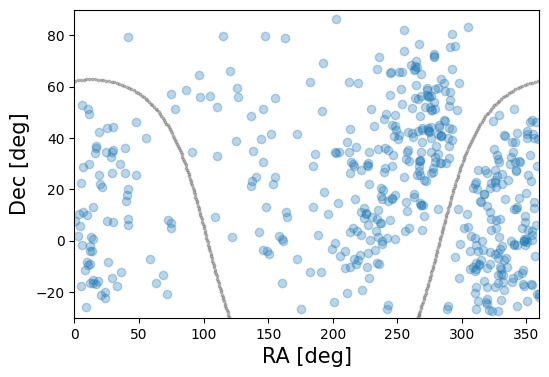

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(gal_plane_ra, gal_plane_dec, s=3, c="gray", alpha=0.5)
ax.scatter(query_results["meanra"], query_results["meandec"], alpha=0.3)
ax.set_xlabel("RA [deg]", fontsize=15)
ax.set_ylabel("Dec [deg]", fontsize=15)
ax.set_xlim([0, 360])
ax.set_ylim([-30, 90]);

### Generate an ALeRCE Explorer link for the first 200 objects (maximum accepted by the interface)

In [19]:
def print_link(index=None, classifier="stamp_classifier"):
    if len(index) == 1:
        expr = "https://alerce.online/object/" + index[0]
    else:
        expr1 = "https://alerce.online/?oid="
        expr2 = "&oid=".join(list(index))
        expr3 = "&selectedClassifier=" + classifier + "&page=1"
        expr = expr1 + expr2 + expr3
    
    display(HTML("<a href='%s' target=\"_blank\"> %s <a>" % (expr, expr)))

In [20]:
index = query_results["oid"].iloc[0:200].tolist()
print_link(index=index)

We can open this link in a browser to continue our exploration :)